# MLP model with new data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from livemodel_mlp import Preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, ReLU, Dropout, Softmax
from tensorflow.math import confusion_matrix

## Load Data

In [2]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

file_names = ['asdf-honey-0621-2017.csv',
              'asdf-honey-0621-2030.csv']

file_paths = [os.path.join(root_path, os.path.join('dataset', f)) for f in file_names]

In [3]:
x_names = ['L%d%c' % (i, c) for i in range(21) for c in ['x', 'y', 'z']]
y_names = ['a', 's', 'd', 'f']

col_names = x_names + y_names

dfs = [pd.read_csv(f, names=col_names) for f in file_paths]
df = pd.concat(dfs, axis=0)

df = df.dropna()

df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df

,L0x,L0y,L0z,L1x,L1y,L1z,L2x,L2y,L2z,L3x,...,L19x,L19y,L19z,L20x,L20y,L20z,a,s,d,f
0,0.198189,0.887018,-0.000048,0.298714,0.839586,-0.037709,0.368166,0.760356,-0.084916,0.415815,...,0.092235,0.442132,-0.165888,0.097163,0.372950,-0.173152,0,0,1,0
1,0.257993,0.863501,-0.000009,0.347506,0.813550,-0.055071,0.412186,0.751654,-0.127558,0.459183,...,0.132011,0.536523,-0.346406,0.136393,0.478623,-0.372104,0,0,1,0
2,0.200646,0.883796,-0.000016,0.301321,0.836918,-0.033009,0.365926,0.752011,-0.074270,0.407175,...,0.100599,0.447423,-0.146337,0.108284,0.381907,-0.153410,0,0,0,1
3,0.259260,0.866459,-0.000034,0.354849,0.816333,-0.055939,0.426554,0.760432,-0.122843,0.475032,...,0.172537,0.494686,-0.276702,0.178477,0.434369,-0.289233,0,1,0,0
4,0.257754,0.891601,-0.000030,0.350177,0.833595,-0.060832,0.420321,0.769120,-0.133471,0.463455,...,0.164746,0.509793,-0.295692,0.172684,0.445099,-0.312764,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15159,0.253538,0.875880,0.000006,0.349841,0.823322,-0.058255,0.420329,0.765182,-0.130687,0.468080,...,0.158931,0.534765,-0.328683,0.169197,0.475226,-0.353380,0,0,0,0
15160,0.261685,0.878910,-0.000018,0.353439,0.823151,-0.056519,0.420951,0.759636,-0.125183,0.464602,...,0.159931,0.498907,-0.270822,0.169826,0.433853,-0.284960,0,0,0,1
15161,0.265229,0.874631,-0.000042,0.357974,0.820110,-0.052835,0.427909,0.763686,-0.117690,0.473382,...,0.174647,0.497612,-0.253458,0.182819,0.436650,-0.266850,0,0,0,1
15162,0.197911,0.893060,-0.000011,0.298040,0.835610,-0.035777,0.367297,0.751584,-0.080128,0.413410,...,0.071958,0.456863,-0.177295,0.066849,0.390235,-0.187193,0,0,1,0


## Preprocessing

In [5]:
# add 'none' label
df['none'] = (df.a + df.s + df.d + df.f == 0).astype(int)

y_names.append('none')
col_names.append('none')

In [6]:
none_idx = df[df.none == 1].index

mask = np.arange(0, len(none_idx))
np.random.shuffle(mask)

drop_rate = 0.6
drop_len = int(len(none_idx)*drop_rate)
drop_idx = none_idx[mask[:drop_len]]

df = df.drop(drop_idx, axis=0).reset_index(drop=True)

In [7]:
# x-y split
x_df, y_df = df[x_names], df[y_names]

print('x_df:', x_df.shape)
print('y_df:', y_df.shape)

x_df: (11704, 63)
y_df: (11704, 5)


In [8]:
# stratified train-test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_idx, test_idx = next(sss.split(x_df, y_df))

x_train = x_df.loc[train_idx].values
y_train = y_df.loc[train_idx].values

x_test = x_df.loc[test_idx].values
y_test = y_df.loc[test_idx].values

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (10533, 63)
y_train: (10533, 5)
x_test: (1171, 63)
y_test: (1171, 5)


In [9]:
# hands data preprocessor
preprocessor = Preprocessing(gamma_smoothing=True,
                             local_minmax=False)

In [10]:
results = []
for x in (x_train, x_test):
    result = []
    for row in x:
        res = preprocessor.process(row)
        result.append(res)
    results.append(result)
    preprocessor.reset()

x_train = np.array(results[0])
x_test  = np.array(results[1])

## Model

In [11]:
model = Sequential([
    InputLayer(input_shape=(63,)),

    Dense(32, kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),

    Dense(16, kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),

    Dense(5, kernel_initializer='he_normal'),
    Softmax()
])

In [12]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
264/264 [==============================] - 2s 4ms/step - loss: 1.7530 - accuracy: 0.2762 - val_loss: 1.5252 - val_accuracy: 0.3469
Epoch 2/50
264/264 [==============================] - 1s 3ms/step - loss: 1.4447 - accuracy: 0.3816 - val_loss: 1.6031 - val_accuracy: 0.3000
Epoch 3/50
264/264 [==============================] - 1s 3ms/step - loss: 1.3422 - accuracy: 0.4505 - val_loss: 1.5613 - val_accuracy: 0.2534
Epoch 4/50
264/264 [==============================] - 1s 2ms/step - loss: 1.2758 - accuracy: 0.4766 - val_loss: 1.3194 - val_accuracy: 0.4347
Epoch 5/50
264/264 [==============================] - 1s 2ms/step - loss: 1.2282 - accuracy: 0.5040 - val_loss: 1.2445 - val_accuracy: 0.4727
Epoch 6/50
264/264 [==============================] - 1s 2ms/step - loss: 1.1995 - accuracy: 0.5190 - val_loss: 1.8045 - val_accuracy: 0.4252
Epoch 7/50
264/264 [==============================] - 0s 2ms/step - loss: 1.1786 - accuracy: 0.5328 - val_loss: 1.3914 - val_accuracy: 0.3977
Epoch 

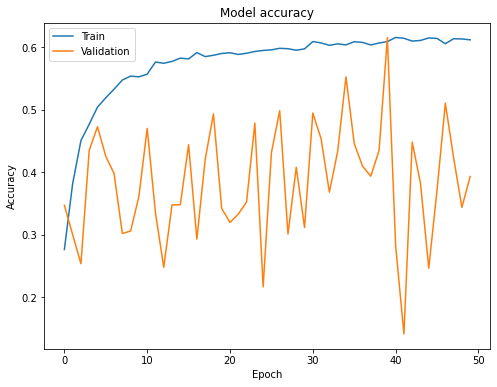

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [15]:
model.evaluate(x_test, y_test, verbose=2)

37/37 - 0s - loss: 1.2440 - accuracy: 0.4150


[1.2439550161361694, 0.4150298833847046]

In [16]:
predict = model.predict(x_test)

In [17]:
model.save('saved_model/new_model_mlp.h5')

In [18]:
conf_predict = []
conf_y_test = []

for i in range(len(predict)):
    conf_predict.append(predict[i].argmax())
    conf_y_test.append(y_test[i].argmax())

conf = confusion_matrix(conf_y_test, conf_predict).numpy()

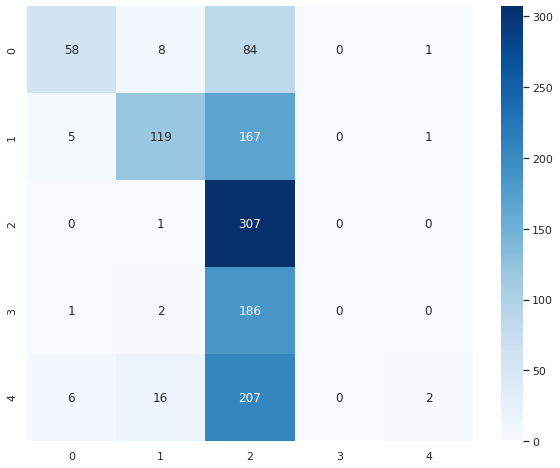

In [19]:
sns.set(rc={'figure.figsize':(10, 8)})

labels = [f'{val:d}' for val in conf.flatten()]
labels = np.array(labels).reshape(5, 5)

sns.heatmap(conf, annot=labels, fmt='', cmap='Blues')
plt.show()